<a href="https://colab.research.google.com/github/Maria-Ul/Inverse-Scattering-Problem/blob/master/Validate_on_experimental_data_latex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
import math
from sklearn.metrics import mean_absolute_error,  mean_absolute_percentage_error


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Dataset(Dataset):

    def __init__(self, csv_file, all_filenames, root_dir, transform=None):

        self.data = pd.read_csv(csv_file , index_col=0 , header=0).to_numpy()

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        features = np.array(sample[2:],  dtype=np.float32)
        labels = np.array([sample[0], sample[1]], dtype=np.float32)

        if self.transform is not None:
            sample = self.transform(theta_array = torch.linspace(10, 65, 256), data_arr = features, noise = True)

        return  features, labels



In [ ]:
class Latex_Dataset_256_length(Dataset):

    def __init__(self, csv_file, all_filenames, root_dir, transform=None):

        self.data = pd.read_csv(csv_file,  delimiter = '\t', header = None).to_numpy()

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        angles = np.array(sample[256:],  dtype=np.float32)
        indicatrice = np.array(sample[:256],  dtype=np.float32)

        indicatrice_interpol = np.interp(torch.linspace(10, 65, 256),angles, indicatrice)

        #Преобразование M функцией
        if self.transform is not None:
            indicatrice_new = self.transform(theta_array = torch.linspace(10, 65, 256), data_arr = indicatrice_interpol, noise = False)

        return  np.array(indicatrice_new,  dtype=np.float32)


In [ ]:
def Mal_func(theta_array , data_arr, noise = False, snr = 3):
  vector_length = len(theta_array)
  w_array = np.zeros(vector_length)
  for i in range(vector_length):
      theta = theta_array[i]
      w = 1/theta*math.exp(-2*(math.log(theta/54, math.e))**2)
      w_array[i] = w
      data_arr[i] = data_arr[i]*w_array[i]

  if noise == True:
    min_val = min(data_arr)
    for i in range(len(data_arr)):
      data_arr[i] = data_arr[i]+(2*np.random.random_sample() - 1)*min_val/snr
  return data_arr

In [ ]:
train_data = Dataset(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/data.csv', all_filenames = 0,
                                           root_dir='content/drive/MyDrive/Scattering_Group',
                                           transform = Mal_func)
test_data = Dataset(csv_file='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/test_data.csv', all_filenames = 0,
                                           root_dir='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/',
                                           transform = Mal_func )
val_data = Latex_Dataset_256_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_2.txt', all_filenames = 0,
                                           root_dir=' ', transform = Mal_func)

In [ ]:
batch_size = 50
data_size = len(train_data)

train_fraction = 1
train_split = int(np.floor((train_fraction) * data_size))

indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices = indices#indices[:train_split]
train_sampler = SubsetRandomSampler(train_indices)

# сделаем loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))


#Check on latex

val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))

Mie_res = pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_fit_res_2.txt', header = None, delimiter = '\t')

d_n = Mie_res.iloc[:,1].to_numpy()#mkm
ri_n = Mie_res.iloc[:,2].to_numpy()
d_sd = Mie_res.iloc[:,5].to_numpy()#mkm
ri_sd = Mie_res.iloc[:,6].to_numpy()


In [ ]:
def metric_2sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd):
    cross_area = 0
    d_counter = 0
    ri_counter = 0
    length = len(d_pred)
    if len(d_pred)!=len(d_n): print('error in metric_2sd_area_percent')
    for i in range(length):
      d_n_i = d_n[i]
      d_pred_i = d_pred[i]
      d_sd_i = d_sd[i]
      ri_n_i = ri_n[i]
      ri_pred_i = ri_pred[i]
      ri_sd_i = ri_sd[i]

      if abs(d_n_i-d_pred_i)<=2*d_sd_i and abs(ri_n_i-ri_pred_i)<=2*ri_sd_i:
        cross_area+=1
      if abs(d_n_i-d_pred_i)<=2*d_sd_i:
        d_counter+=1
      if abs(ri_n_i-ri_pred_i)<=2*ri_sd_i:
        ri_counter+=1

    return cross_area/length*100, d_counter/length*100, ri_counter/length*100



In [ ]:
def metric_1sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd):
    cross_area = 0
    d_counter = 0
    ri_counter = 0
    length = len(d_pred)
    if len(d_pred)!=len(d_n): print('error in metric_2sd_area_percent')
    for i in range(length):
      d_n_i = d_n[i]
      d_pred_i = d_pred[i]
      d_sd_i = d_sd[i]
      ri_n_i = ri_n[i]
      ri_pred_i = ri_pred[i]
      ri_sd_i = ri_sd[i]

      if abs(d_n_i-d_pred_i)<=d_sd_i and abs(ri_n_i-ri_pred_i)<=ri_sd_i:
        cross_area+=1
      if abs(d_n_i-d_pred_i)<=d_sd_i:
        d_counter+=1
      if abs(ri_n_i-ri_pred_i)<=ri_sd_i:
        ri_counter+=1

    return cross_area/length*100, d_counter/length*100, ri_counter/length*100



In [ ]:
def metrics_mape(prediction, labels):
  return np.mean(abs((prediction-labels)/labels)*100)

def loss_mape(prediction, labels):
  return  torch.mean(abs(prediction-labels)/labels*100)

In [ ]:
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

In [ ]:
class ConvNet_new(nn.Module):
    def __init__(self):
        super(ConvNet_new, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=21, kernel_size=7, padding=3)#lout = 256
        #Lin = Lout => p = (k_s-1)/2
        #Lout = Lin
        self.conv2 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256
        self.conv3 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256
        self.conv4 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256

        #Lout = Lin/2 and channels_out*2 (due to 34-layers plains and 34-layers ResNet)  => p = (k-1)/2 - Lin/4
        self.conv5 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=3, stride = 2, padding=1)# lout =128
        #Lout = Lin
        self.conv6 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)#lout = 128
        self.conv7 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)#lout = 128

        #Lout = Lin/2 and channels_out*2
        self.conv8 = nn.Conv1d(in_channels=42, out_channels=84, kernel_size=3, stride = 2, padding=1)# lout = 64
        #Lout = Lin
        self.conv9 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)#lout = 64
        self.conv10 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)#lout = 64

        #reducing out_ch value. Lout = Lin
        self.conv11= nn.Conv1d(in_channels=84, out_channels=42, kernel_size=1, padding=0)#lout = 64
        self.conv12= nn.Conv1d(in_channels=42, out_channels=21, kernel_size=1, padding=0)#lout =64
        self.conv13= nn.Conv1d(in_channels=21, out_channels=1, kernel_size=1, padding=0)#lout = 64

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        return x

#75353 params

In [ ]:
class Modified_seven_ConvNet(nn.Module):
    def __init__(self):
        super(Modified_seven_ConvNet, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm1d(num_features=2)
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(num_features=4)
        self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=7, padding=2)
        self.bn4 = nn.BatchNorm1d(num_features=8)
        self.conv4 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=11, padding=2)
        self.bn5 = nn.BatchNorm1d(num_features=16)
        self.conv5 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=13, padding=2)
        self.bn6 = nn.BatchNorm1d(num_features=32)
        self.conv6 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=17, padding=2)
        self.bn7 = nn.BatchNorm1d(num_features=16)
        self.conv7 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=23, padding=2)
        self.bn8 = nn.BatchNorm1d(num_features=8)
        self.fc1 = nn.Linear(1696, 180)#
        self.fc2 = nn.Linear(180, 2)


    def forward(self, x):
        x = self.bn1(x)
        x = F.relu(self.conv1(x))
        x = self.bn2(x)
        x = F.relu(self.conv2(x))
        x = self.bn3(x)
        x = F.relu(self.conv3(x))
        x = self.bn4(x)
        x = F.relu(self.conv4(x))
        x = self.bn5(x)
        x = F.relu(self.conv5(x))
        x = self.bn6(x)
        x = F.relu(self.conv6(x))
        x = self.bn7(x)
        x = F.relu(self.conv7(x))
        x = self.bn8(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


#326064

In [ ]:
model = Modified_seven_ConvNet()
total_params  = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

326064

In [ ]:
def train(num_epochs, loss ,metrics, scheduler, val_loader, train_loader):
    loss_history = []
    train_history = []
    val_history_cross = []
    val_history_d = []
    val_history_n = []

    epochs = np.linspace(0,num_epochs, num_epochs)
    for epoch in range(num_epochs):
        model.train()
        ave_loss, ave_metrics, prediction, labels = train_epoch(model, train_loader, loss, metrics)
        scheduler.step()
        val_cross_area_value, val_d_area_value, val_n_area_value = val_epoch(model, val_loader)

        val_history_cross.append(float(val_cross_area_value))
        val_history_d.append(float(val_d_area_value))
        val_history_n.append(float(val_n_area_value))

        loss_history.append(float(ave_loss))
        train_history.append(float(ave_metrics))

        print("Epoch: %d, Average loss: %f, average metric (mape): %f" % ((epoch+1), ave_loss, ave_metrics))#, val metric (mape): %f , val_history_value))

    return [loss_history, train_history, val_history_cross, val_history_d, val_history_n, prediction, labels, epochs]


In [ ]:
def train_epoch(model, train_loader, loss, metrics):
    metrics_accum = 0
    loss_accum = 0
    prediction_arr = []
    labels_arr = []
    for i_step, (x, y) in enumerate(train_loader):
        x = x.unsqueeze(1)
        prediction = model(x.to(device)).squeeze(1)
        loss_value = loss((prediction/y.to(device)), torch.ones(prediction.shape).to(device))
        metrics_value= metrics(prediction.cpu().detach().numpy(), y.detach().numpy())

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        metrics_accum += metrics_value
        loss_accum += loss_value.item()

        prediction_arr.append(prediction.cpu().detach().numpy())
        labels_arr.append(y.detach().numpy())

    ave_loss = loss_accum/(i_step+1)
    ave_metrics = metrics_accum/(i_step+1)

    return ave_loss, ave_metrics, prediction_arr, labels_arr


In [ ]:
def val_epoch(model, val_loader):
    model.eval()
    with torch.no_grad():
      metrics_accum_cross = 0
      metrics_accum_d = 0
      metrics_accum_n = 0

      for i_step, (x) in enumerate(val_loader):
        x = x.unsqueeze(1)
        val_prediction = model(x.to(device))
        prediction_arr_val = (val_prediction.cpu().detach().numpy())

        ri_pred = prediction_arr_val[:,0]*1.333
        d_pred = prediction_arr_val[:,1]/(1.333*math.pi/0.66) #mkm
        metric_sd = metric_2sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)
        metrics_accum_cross += metric_sd[0]
        metrics_accum_d += metric_sd[1]
        metrics_accum_n += metric_sd[2]

    model.train()
    return metrics_accum_cross/(i_step+1),metrics_accum_d/(i_step+1), metrics_accum_n/(i_step+1)

In [ ]:
def test(metrics):
  model.eval()
  with torch.no_grad():
    for i_step, (x, y) in enumerate(test_loader):
        x = x.unsqueeze(1)
        prediction = model(x.to(device)).squeeze(1)

        metrics_value= metrics(prediction.cpu().detach().numpy(), y.detach().numpy())
        prediction_arr = (prediction.cpu().detach().numpy())
        labels_arr = (y.cpu().detach().numpy())

  labels_arr = np.squeeze(labels_arr)
  prediction_arr = np.squeeze(prediction_arr)


  m_true = labels_arr[:,0]
  m_pred = prediction_arr[:,0]
  print('MAPE m-1  = ',mean_absolute_percentage_error(m_true-1, m_pred-1)*100 , '\n')
  print('mae m ', mean_absolute_error(m_true, m_pred), '\n')
  x_true = labels_arr[:, 1]
  x_pred = prediction_arr[:,1]
  print('MAPE x % = ' , mean_absolute_percentage_error(x_true, x_pred)*100, '\n')

  print("Ошибка суммарная %: " , mean_absolute_percentage_error(y.detach().numpy(), prediction.cpu().detach().numpy())*100*2, '\n')

  return prediction_arr, labels_arr

In [ ]:
def graphs(loss_history, metrics_history, val_history_cross, val_history_d, val_history_n , prediction_arr, labels_arr, epochs):
    plt.figure(figsize=(12,12))
    plt.subplot(421)
    plt.plot(epochs, loss_history, label = 'loss')
    plt.xlabel('Номер эпохи')
    plt.ylabel('Функция потери')
    plt.yscale('log')
    plt.legend()

    plt.subplot(422)
    plt.plot(epochs, metrics_history, label = 'metrics = mape ')
    plt.yscale('log')
    plt.legend()


    plt.subplot(423)
    plt.plot(epochs, val_history_cross, label = 'cross 2 sigma')
    #plt.yscale('log')
    plt.legend()

    plt.subplot(424)
    plt.plot(epochs, val_history_d, label = 'd 2 sigma ')
    #plt.yscale('log')
    plt.legend()

    plt.subplot(425)
    plt.plot(epochs, val_history_n, label = 'n 2 sigma ')
    #plt.yscale('log')
    plt.legend()



    plt.subplot(426)
    plt.plot(prediction_arr[:,0],prediction_arr[:,1], linewidth = 0, marker = 'o', label = 'pred' )
    plt.plot(labels_arr[:,0],labels_arr[:,1], linewidth = 0, marker = 'o', label = 'true' )

    plt.xlabel('Относительный показатель преломления m')
    plt.ylabel('Дифракционный параметр x')
    plt.legend()


    plt.subplot(427)
    m_true = labels_arr[:, 0]
    m_pred = prediction_arr[:,0]
    m_err = abs(m_true[:] - m_pred[:])
    plt.hist(m_err, bins = 50)

    length =len(m_err)
    text_1 = "%s" % float('%.2g' % np.median(m_err[(length - 11):(length-1)]))
    print('Абсолютная ошибка m = ' + text_1)
    plt.xlabel('Ошибка по m')
    plt.ylabel('Число частиц')

    plt.subplot(428)
    x_true = labels_arr[:, 1]
    x_pred = prediction_arr[:,1]
    x_err = abs(x_true - x_pred)/x_true*100
    plt.hist(x_err, bins = 50)

    length =len(x_err)
    text_1 = "%s" % float('%.2g' % np.median(x_err[(length - 11):(length-1)]))  #'%s' % float('%.1g' % 0.012)
    print('mape_x = ' + text_1 + '%')
    plt.xlabel('Ошибка по x')
    plt.ylabel('Число частиц')

    plt.show()

Проверка работы сети на данных - латексных шарах

In [ ]:
PATH = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.pt'


In [ ]:
PATH = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/ConvNet_best_1sd_metric_2.pt'

In [ ]:
model = ConvNet_new().cuda()

optimizer = torch.optim.Adam(model.parameters())
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'], strict=False)#
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']
loss = checkpoint['loss']

loss_history = checkpoint['loss_history']
train_history = checkpoint['train_history']
val_history_cross = checkpoint['val_history_cross']
val_history_d = checkpoint['val_history_d']
val_history_n = checkpoint['val_history_n']

# start = time.time()

# prediction_arr, labels_arr = test(metrics = metrics_mape)#history[3], history[4] #
# end = time.time()

# graphs(loss_history,  train_history, val_history_cross, val_history_d, val_history_n , prediction_arr, labels_arr, epochs)
# print(end-start, len(prediction_arr))

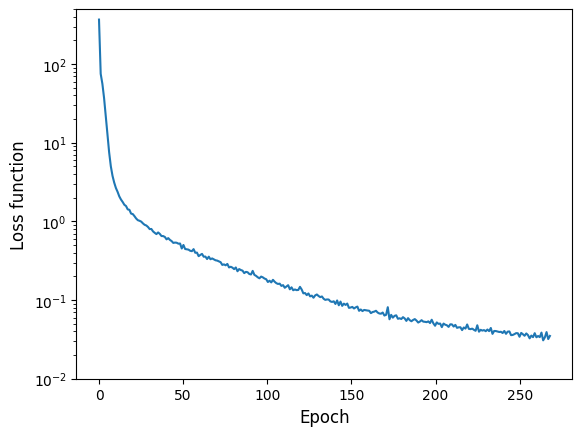

In [ ]:

plt.plot(epochs, loss_history)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss function', fontsize = 12)
plt.yscale('log')
plt.ylim(0.01,500)

plt.savefig('loss_function_1dvgg.svg')



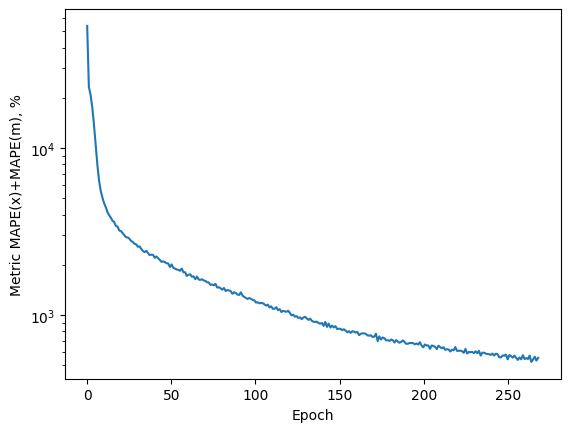

In [ ]:

plt.plot(epochs, train_history)

plt.xlabel('Epoch')
plt.ylabel('Metric MAPE(x)+MAPE(m), %')
plt.yscale('log')
plt.savefig('metric_convnet.svg')


Анализ

In [ ]:
#@title
x_true = labels_arr[:, 1]
x_pred = prediction_arr[:,1]
x_err = abs(x_true - x_pred)/x_true*100

length =len(x_err)
text_1 = "%s" % float('%.2g' % np.median(x_err[(length - 11):(length-1)]))  #'%s' % float('%.1g' % 0.012)
print('mape_x = ' + text_1 + '%')
plt.xlabel('Percentage error of size x', fontsize=14)
plt.ylabel('Number of particles', fontsize=14)
plt.hist(x_err, bins = 50)
# plt.text(x = 100, y = 100,  s = str('MAPE(x) = '+ text_1+'%'))
plt.text(1.5, 2000, str('MAPE(x) = '+ text_1+'%'), fontsize=14)

plt.savefig('MAPE x distribution prime.svg')


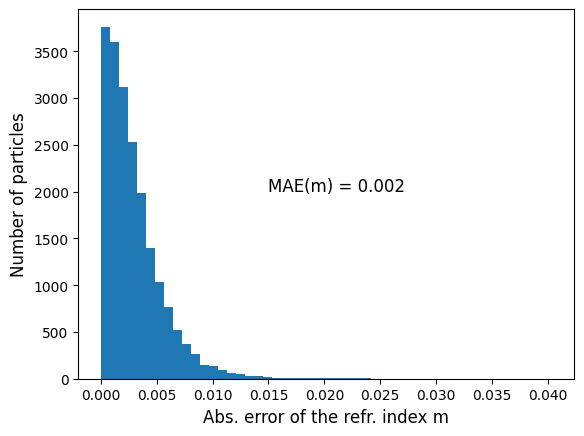

In [ ]:
#@title
m_true = labels_arr[:, 0]
m_pred = prediction_arr[:,0]
m_err = abs(m_true[:] - m_pred[:])

length =len(m_err)
text_1 = "%s" % float('%.2g' % np.median(m_err[(length - 11):(length-1)]))
# print('Абсолютная ошибка m = ' + text_1)
plt.xlabel('Abs. error of the refr. index m', fontsize=12)
plt.ylabel('Number of particles', fontsize=12)
plt.hist(m_err, bins = 50)
plt.text(0.015, 2000, str('MAE(m) = '+ text_1), fontsize=12)

plt.savefig('MAE m distribution_convnet 1dvgg.svg')


Подсчет времени работы

In [ ]:
import time

In [ ]:
model.eval()
start = time.time()
with torch.no_grad():

  for i_step, (x) in enumerate(val_loader):
    x = x.unsqueeze(1).to(device)
    val_prediction = model(x)
end = time.time()

prediction_arr_val = (val_prediction.cpu().detach().numpy())
# prediction_arr_val = np.squeeze(prediction_arr_val)

ri_pred = prediction_arr_val[:,0]*1.333
d_pred = prediction_arr_val[:,1]/(1.333*math.pi/0.66) #mkm
metric_sd = metric_1sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)


In [ ]:
print(end - start)

3.1558525562286377


Подсчет метрик

1 standard deviation

In [ ]:
cross_area, d_area, ri_area = metric_sd

In [ ]:
cross_area, d_area, ri_area

(0.9375, 7.187499999999999, 32.5)

2 standard deviation

In [ ]:
metric_sd = metric_2sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)
cross_area, d_area, ri_area = metric_sd
cross_area, d_area, ri_area

(7.8125, 11.25, 63.4375)